<a href="https://colab.research.google.com/github/shapi88/tensorflow_book/blob/feature-tf-overfitting/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling up (🍔👁 Food Vision mini)


We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).


Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).


Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf


Our baseline to beat is 50.76% accuracy across 101 classes.


-------------------------------------------------------------------
See full course materials on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning

In [1]:
# Check to see if we're using a GPU
!nvidia-smi

Sat Jun 24 10:30:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    47W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a series of helper functions to do different tasks, let's download them.

In [2]:
!wget https://raw.githubusercontent.com/shapi88/tensorflow_book/main/helpers/helpers.py

--2023-06-24 10:30:05--  https://raw.githubusercontent.com/shapi88/tensorflow_book/main/helpers/helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10245 (10K) [text/plain]
Saving to: ‘helpers.py’

helpers.py          100%[===================>]  10.00K  --.-KB/s    in 0s      

2023-06-24 10:30:05 (109 MB/s) - ‘helpers.py’ saved [10245/10245]



In [3]:
# Import helper functions we're going to use in this notebook
from helpers import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir
import tensorflow as tf

### 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the image_data_modification notebook - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2023-06-24 10:30:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 64.233.170.128, 142.251.175.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  23.1MB/s    in 70s     

2023-06-24 10:31:19 (22.2 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/red_velvet_cake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/foie_gras'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/gyoza'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pancakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/takoyaki'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/deviled_eggs'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/breakfast_burrito'.
There are 0 directories and 75 images in '101_food

In [6]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:

* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [7]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [9]:
#Augmenting Data
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomHeight(0.2),
    #tf.keras.layers.Rescaling(1/255.), # not necessary for effienct net 0
    tf.keras.layers.RandomFlip("horizontal")
], name="data_augmentation_layer")

In [12]:
#Create a base model with efficient net b0
base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False)
base_model.trainable = False

16705208/16705208 [==============================] - 2s 0us/step


In [13]:
input_shape = (224, 224, 3)
number_of_output_nuerons = len(train_data_all_10_percent.class_names)
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_polling_2d")(x)
outputs = tf.keras.layers.Dense(number_of_output_nuerons, activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

In [14]:
# Get a summary of model we've created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_polling_2d (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_____________________________________________

In [27]:
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

history_all_classes_10_percent = model.fit(
    train_data_all_10_percent,
    epochs=5,
    validation_data=test_data,
    validation_steps=int(0.15*len(test_data)),
    callbacks=[
        checkpoint_callback
    ]
)

Epoch 1/5
237/237 [==============================] - 29s 89ms/step - loss: 1.3585 - accuracy: 0.6639 - val_loss: 1.6836 - val_accuracy: 0.5596
Epoch 2/5
237/237 [==============================] - 20s 85ms/step - loss: 1.2235 - accuracy: 0.6931 - val_loss: 1.6827 - val_accuracy: 0.5572
Epoch 3/5
237/237 [==============================] - 19s 79ms/step - loss: 1.1254 - accuracy: 0.7251 - val_loss: 1.6941 - val_accuracy: 0.5493
Epoch 4/5
237/237 [==============================] - 21s 87ms/step - loss: 1.0466 - accuracy: 0.7420 - val_loss: 1.6676 - val_accuracy: 0.5564
Epoch 5/5
237/237 [==============================] - 16s 69ms/step - loss: 0.9914 - accuracy: 0.7535 - val_loss: 1.6512 - val_accuracy: 0.5612


In [28]:
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 40s 51ms/step - loss: 1.5166 - accuracy: 0.5958


[1.5165671110153198, 0.5958415865898132]

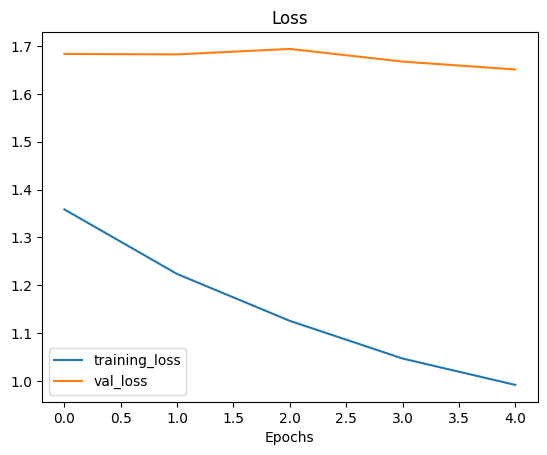

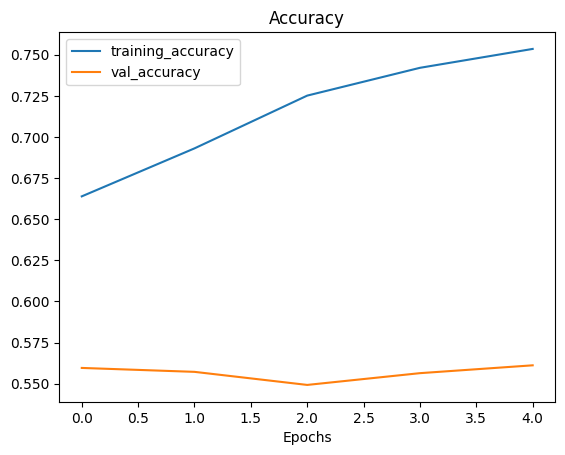

In [29]:
plot_loss_curves(history_all_classes_10_percent)

>** 🤔 Question: **What do these curves suggest? Hint: ideally, the two curves should be very similar to each other, if not it may suggest that our model is overfitting (performing too well on the training data and not generalizing to unseen data).

## Fine Tuning

In [31]:
base_model.trainable = True
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [32]:
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

In [34]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
sequential_1 True
efficientnetb0 True
global_average_polling_2d True
output_layer True
